![UBA](assets/UBA_header_black.png)

# Dataset seleccionado: BA Ecobici
Contiene información sobre los viajes realizados a través del servicio público de bicicletas BA Ecobici, que opera en la Ciudad Autónoma de Buenos Aires.

In [70]:
import pandas as pd
import numpy as np
import pathlib
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FixedLocator
import requests
import zipfile
import folium

# Ingesta de los datos

In [71]:
USUARIOS_FILE_URL = r"https://cdn.buenosaires.gob.ar/datosabiertos/datasets/transporte-y-obras-publicas/bicicletas-publicas/badata_ecobici_usuarios_2024.csv"
RECORRIDOS_FILE_URL = r"https://cdn.buenosaires.gob.ar/datosabiertos/datasets/transporte-y-obras-publicas/bicicletas-publicas/badata_ecobici_recorridos_realizados_2024.zip"
USUARIOS_CSV = pathlib.Path("./datasets/badata_ecobici_usuarios_2024.csv")
RECORRIDOS_ZIP = pathlib.Path("./datasets/badata_ecobici_recorridos_realizados_2024.zip")
RECORRIDOS_CSV = pathlib.Path("./datasets/badata_ecobici_recorridos_realizados_2024.csv")

In [72]:
# Descarga de los archivos
GET_FILES = False

if GET_FILES:
    def download_file(url, dest_path):
        response = requests.get(url, stream=True)
        response.raise_for_status()
        with open(dest_path, 'wb') as f:
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)


    download_file(USUARIOS_FILE_URL, USUARIOS_CSV)
    download_file(RECORRIDOS_FILE_URL, RECORRIDOS_ZIP)

    with zipfile.ZipFile(RECORRIDOS_ZIP) as zip_ref:
        zip_contents = zip_ref.namelist()
        if zip_contents:
            zip_ref.extract(zip_contents[0], path=RECORRIDOS_CSV.parent)
            extracted_file = RECORRIDOS_CSV.parent / zip_contents[0]
            extracted_file.rename(RECORRIDOS_CSV)

    RECORRIDOS_ZIP.unlink()

In [73]:
users_df = pd.read_csv(USUARIOS_CSV)
rides_df = pd.read_csv(RECORRIDOS_CSV)

# Hipótesis
- Los fines de semana hay una mayor cantidad de usuarios nuevos
- Los fines de semana se realizan más recorridos
- Las estaciones ubicadas cerca de centros de transbordo (trenes, subtes y colectivos) son las más utilizadas
- La mayoría de los viajes ocurre en horas pico laborales
- La duración promedio de los recorridos es mayor los fines de semana
- Las estaciones ubicadas en zonas comerciales son más usadas en horario laboral
- En invierno disminuye la cantidad de viajes

# Posibilidades abiertas para el futuro
Si bien no forman parte del objetivo actual, este análisis podría extenderse utilizando modelos de aprendizaje automático para:
- Predecir demanda futura por estación
- Estimar la duración de un recorrido en función del día y hora de inicio <br>
<br>
Para esto, se podría cruzar con otros datasets:
- Clima (Servicio Metereológico Nacional)
- Transporte público (datos de viajes en otros medios de transporte)
- Eventos masivos (recitales, eventos deportivos, eventos gratuitos del GCBA, etc.)

# Dataset de usuarios (CSV)
Contiene el listado de usuarios del servicio, que se dieron de alta en 2024.

In [74]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197079 entries, 0 to 197078
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   id_usuario      197079 non-null  int64 
 1   genero_usuario  197079 non-null  object
 2   edad_usuario    197079 non-null  int64 
 3   fecha_alta      197079 non-null  object
 4   hora_alta       197079 non-null  object
dtypes: int64(2), object(3)
memory usage: 7.5+ MB


In [75]:
users_df.head()

,id_usuario,genero_usuario,edad_usuario,fecha_alta,hora_alta
0,1083579,OTHER,23,2024-01-01,01:59:02
1,1083608,OTHER,36,2024-01-01,02:55:46
2,1083612,OTHER,38,2024-01-01,03:13:15
3,1083616,FEMALE,21,2024-01-01,03:40:54
4,1083631,MALE,36,2024-01-01,05:02:35


In [76]:
users_df.describe()

,id_usuario,edad_usuario
count,1.970790e+05,197079.000000
mean,1.182078e+06,30.764521
std,5.689283e+04,18.896208
min,1.083538e+06,4.000000
25%,1.132808e+06,21.000000
50%,1.182078e+06,27.000000
75%,1.231348e+06,37.000000
max,1.280619e+06,2021.000000


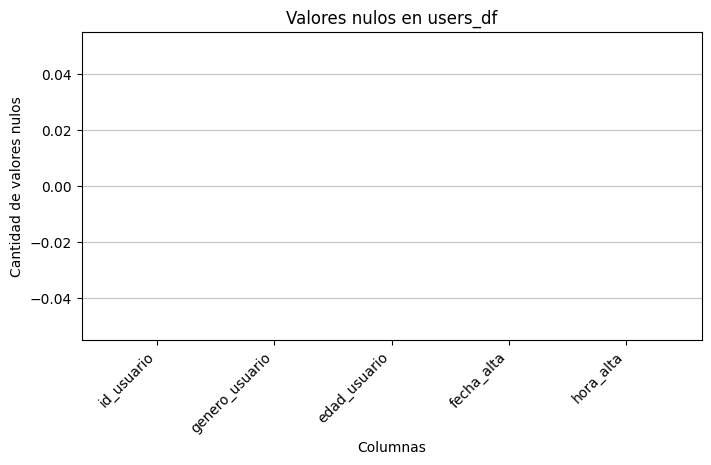

In [77]:
# Exploración de valores nulos
plt.figure(figsize=(8, 4))
plt.grid(axis='y', alpha=0.75)
plt.bar(users_df.columns, users_df.isnull().sum(), align='center', zorder=2)
plt.xticks(rotation=45, ha='right')
plt.title('Valores nulos en users_df')
plt.xlabel('Columnas')
plt.ylabel('Cantidad de valores nulos')
plt.show()

In [78]:
# Usuarios duplicados
duplicated_users = users_df[users_df.duplicated(subset='id_usuario', keep=False)]
print(f"Cantidad de usuarios duplicados: {duplicated_users['id_usuario'].nunique()}")
duplicated_users.sort_values(by='id_usuario').head(10)

Cantidad de usuarios duplicados: 0


,id_usuario,genero_usuario,edad_usuario,fecha_alta,hora_alta


##### Exploración de generos

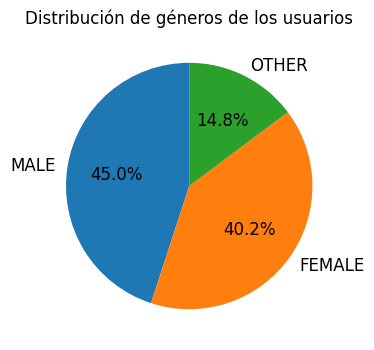

In [79]:
# Pie chart de los géneros de usuarios
plt.figure(figsize=(4, 4))
users_df['genero_usuario'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, fontsize=12)
plt.title('Distribución de géneros de los usuarios')
plt.ylabel('')
plt.show()

In [80]:
# Conteo de usuarios por género
gender_counts = users_df['genero_usuario'].value_counts()
print(gender_counts)

genero_usuario
MALE      88656
FEMALE    79310
OTHER     29113
Name: count, dtype: int64


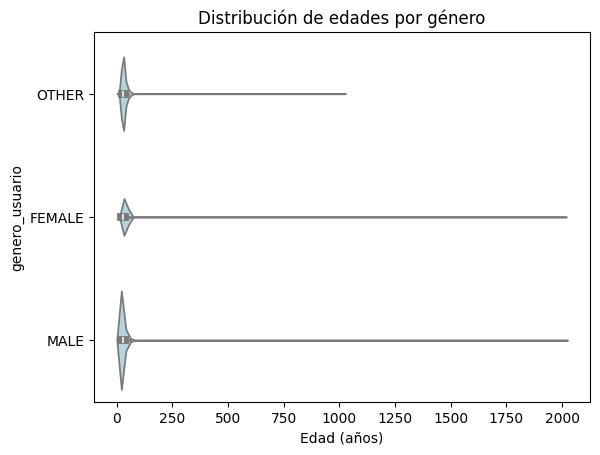

In [81]:
sns.violinplot(y=users_df['genero_usuario'], x=users_df['edad_usuario'], color='lightblue', inner='box')
plt.title('Distribución de edades por género')
plt.xlabel('Edad (años)')
plt.show()

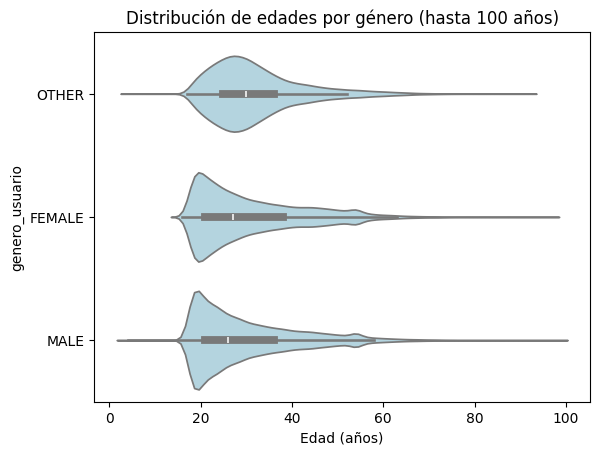

In [82]:
# Violin de edades por género (edades hasta 100 años)
mask_edad = users_df['edad_usuario'] <= 100
sns.violinplot(y=users_df['genero_usuario'][mask_edad], x=users_df['edad_usuario'][mask_edad], color='lightblue', inner='box')
plt.title('Distribución de edades por género (hasta 100 años)')
plt.xlabel('Edad (años)')
plt.show()

##### Exploración de edades

In [83]:
# Edades de usuarios menores de 18 años
users_df[users_df['edad_usuario'] < 18].value_counts('edad_usuario').sort_index()

edad_usuario
4      2
5      4
15     3
16     7
17    16
Name: count, dtype: int64

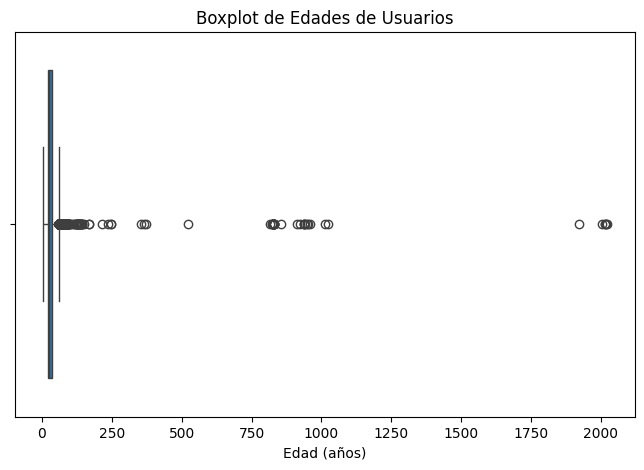

In [84]:
# Boxplot de edades
plt.figure(figsize=(8, 5))
sns.boxplot(x=users_df['edad_usuario'])
plt.title('Boxplot de Edades de Usuarios')
plt.xlabel('Edad (años)')
plt.show()

In [85]:
# Cuartiles en años
Q1 = users_df['edad_usuario'].quantile(0.25)
Q2 = users_df['edad_usuario'].quantile(0.50)
Q3 = users_df['edad_usuario'].quantile(0.75)
IQR = Q3 - Q1

print("Q1 (25%):", Q1)
print("Q2 (Mediana, 50%):", Q2)
print("Q3 (75%):", Q3)
print("IQR (Rango Intercuartílico):", IQR)

Q1 (25%): 21.0
Q2 (Mediana, 50%): 27.0
Q3 (75%): 37.0
IQR (Rango Intercuartílico): 16.0


In [86]:
# Media moda mediana de edades (en años)
mean = users_df['edad_usuario'].mean().round(2)
median = users_df['edad_usuario'].median().round(2)
mode = users_df['edad_usuario'].mode()[0].round(2)
var = users_df['edad_usuario'].var().round(2)
std_dev = users_df['edad_usuario'].std().round(2)

print(f"Media: {mean} años")
print(f"Mediana: {median} años")
print(f"Moda: {mode} años")
print(f"Varianza: {var} años²")
print(f"Desviación estándar: {std_dev} años")

Media: 30.76 años
Mediana: 27.0 años
Moda: 18 años
Varianza: 357.07 años²
Desviación estándar: 18.9 años


In [87]:
print(f"Asímetría de edad: {users_df['edad_usuario'].skew()}")
print(f"Curtosis de edad: {users_df['edad_usuario'].kurtosis()}")

Asímetría de edad: 47.583628237635786
Curtosis de edad: 4173.90573483157


La edad de usuario es altamente asimétrica:
- Tiene muchos valores bajos
- Tiene pocos valores extremadamente altos (estiran la cola a derecha)

La edad de usuario tiene una curtosis muy alta:
- Tiene una distribución 'picuda'
- Tiene una cola bien pesada

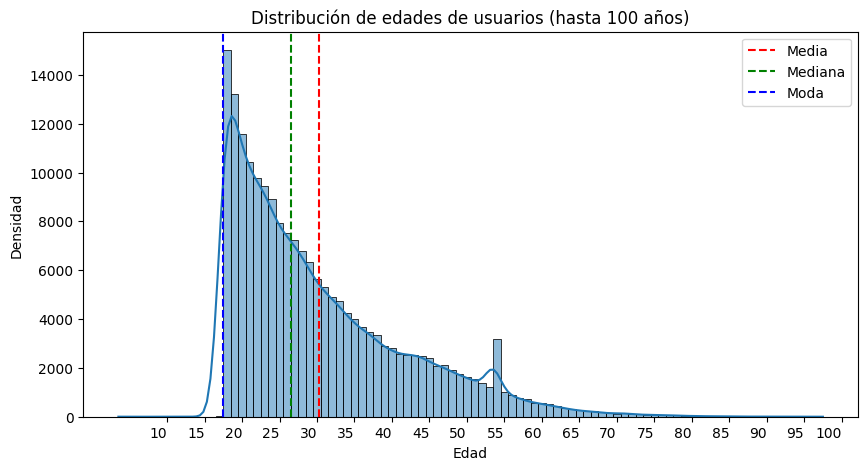

In [88]:
# Histograma de edades (hasta 100 años)
mask_edad = users_df['edad_usuario'] <= 100
plt.figure(figsize=(10, 5))
ax = sns.histplot(users_df[mask_edad]['edad_usuario'], kde=True, binwidth=1)
ticks = [t + 0.5 for t in range(10, 101, 5)]  # Esto es para centrar los bines en los ticks
ax.xaxis.set_major_locator(FixedLocator(ticks))
ax.set_xticklabels([str(int(tick)) for tick in ticks], ha='right')
plt.title('Distribución de edades de usuarios (hasta 100 años)')
plt.xlabel('Edad')
plt.ylabel('Densidad')

# Media, moda y mediana
ax.axvline(mean, color='r', linestyle='--', label='Media')
ax.axvline(median, color='g', linestyle='--', label='Mediana')
ax.axvline(mode, color='b', linestyle='--', label='Moda')
ax.legend()

plt.show()


Text(0, 0.5, 'Densidad')

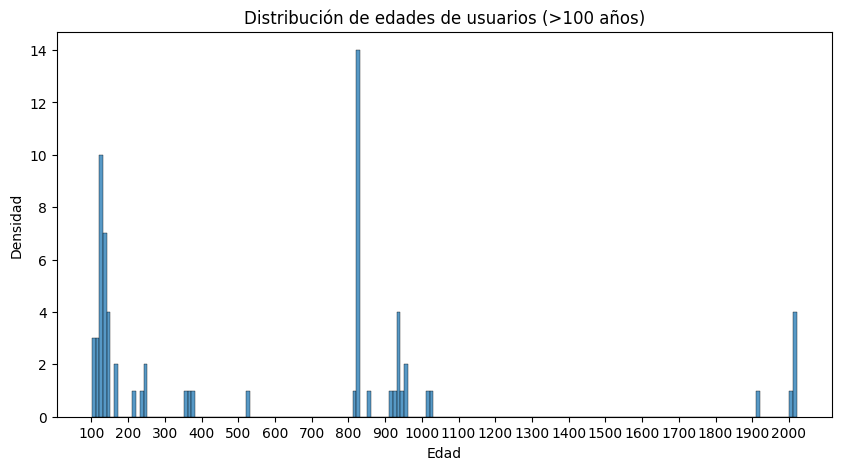

In [89]:
# Histograma de edades de mas de 100 años
mask_edad = users_df["edad_usuario"] > 100
plt.figure(figsize=(10, 5))
sns.histplot(users_df[mask_edad]['edad_usuario'], binwidth=10)
plt.title('Distribución de edades de usuarios (>100 años)')
plt.xticks(range(100, users_df['edad_usuario'].max() + 1, 100))
plt.xlabel('Edad')
plt.ylabel('Densidad')

In [90]:
# 10 usuarios mas 'viejos'
users_df.sort_values(by='edad_usuario', ascending=False).head(10)

,id_usuario,genero_usuario,edad_usuario,fecha_alta,hora_alta
56690,1109473,MALE,2021,2024-02-11,20:24:45
104417,1238144,MALE,2019,2024-10-27,20:08:47
124365,1130915,FEMALE,2016,2024-03-21,21:19:50
184254,1202670,MALE,2016,2024-09-07,18:39:34
66885,1189702,FEMALE,2004,2024-08-09,22:34:35
10936,1150325,FEMALE,1921,2024-04-29,13:33:57
137312,1277262,OTHER,1022,2024-12-27,13:11:42
62421,1167228,MALE,1012,2024-06-16,15:20:11
18616,1199423,OTHER,960,2024-09-02,17:37:56
92904,1279416,OTHER,952,2024-12-30,09:20:27


##### Exploración de fecha y hora de alta

In [91]:
# Parseo de columnas de fecha y hora
users_df['fecha_alta_dt'] = pd.to_datetime(users_df['fecha_alta'], errors='coerce')
users_df['hora_alta_dt'] = pd.to_datetime(users_df['hora_alta'], format='%H:%M:%S', errors='coerce').dt.time
users_df['dia_semana'] = users_df['fecha_alta_dt'].dt.day_name()

In [92]:
# 10 fechas de alta mas repetidas
users_df['fecha_alta_dt'].value_counts().head(10)

fecha_alta_dt
2024-11-09    1720
2024-05-09    1315
2024-10-11    1278
2024-09-29    1197
2024-10-27    1154
2024-11-10    1128
2024-11-18    1119
2024-09-08    1076
2024-01-24    1062
2024-09-15    1041
Name: count, dtype: int64

In [93]:
# 10 horas de alta mas repetidas
users_df['hora_alta_dt'].apply(lambda x: x.hour).value_counts().head(10)

hora_alta_dt
16    18531
15    17762
17    17386
14    15614
18    14997
13    14042
12    13425
11    11756
19    11261
10     8984
Name: count, dtype: int64

In [94]:
# Altas por dia de la semana
users_df['dia_semana'].value_counts()

dia_semana
Sunday       31073
Saturday     28801
Monday       28599
Thursday     27978
Friday       27115
Tuesday      26841
Wednesday    26672
Name: count, dtype: int64

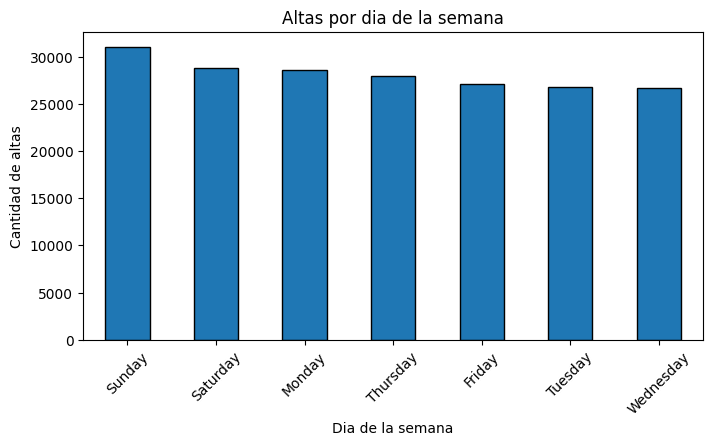

In [95]:
# Bar chart de altas por dia de la semana
plt.figure(figsize=(8, 4))
users_df['dia_semana'].value_counts().plot(kind='bar', edgecolor='black')
plt.title('Altas por dia de la semana')
plt.xlabel('Dia de la semana')
plt.ylabel('Cantidad de altas')
plt.xticks(rotation=45)
plt.show()

# Dataset de recorridos (CSV)
Contiene información de los viajes realizados.

In [96]:
rides_df.info()
# duracion_recorrido está en segundos

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3560404 entries, 0 to 3560403
Data columns (total 17 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   id_recorrido                int64  
 1   duracion_recorrido          int64  
 2   fecha_origen_recorrido      object 
 3   id_estacion_origen          int64  
 4   nombre_estacion_origen      object 
 5   direccion_estacion_origen   object 
 6   long_estacion_origen        float64
 7   lat_estacion_origen         float64
 8   fecha_destino_recorrido     object 
 9   id_estacion_destino         int64  
 10  nombre_estacion_destino     object 
 11  direccion_estacion_destino  object 
 12  long_estacion_destino       float64
 13  lat_estacion_destino        float64
 14  id_usuario                  float64
 15  modelo_bicicleta            object 
 16  genero                      object 
dtypes: float64(5), int64(4), object(8)
memory usage: 461.8+ MB


In [97]:
rides_df.head()

,id_recorrido,duracion_recorrido,fecha_origen_recorrido,id_estacion_origen,nombre_estacion_origen,direccion_estacion_origen,long_estacion_origen,lat_estacion_origen,fecha_destino_recorrido,id_estacion_destino,nombre_estacion_destino,direccion_estacion_destino,long_estacion_destino,lat_estacion_destino,id_usuario,modelo_bicicleta,genero
0,24496816,17,2024-12-31 08:18:58,202,001 - FACULTAD DE DERECHO,Av. Pres. Figueroa Alcorta 2120,-58.390602,-34.583749,2024-12-31 08:19:15,202,001 - FACULTAD DE DERECHO,Av. Pres. Figueroa Alcorta 2120,-58.390602,-34.583749,1166678.0,FIT,FEMALE
1,24492524,2,2024-12-30 19:21:45,251,388 - Plaza Jose C Paz,Dr. Prof. Pedro Chutro 2881,-58.402483,-34.641728,2024-12-30 19:21:47,41,041 - PARQUE PATRICIOS II,Av Caseros 3015,-58.405888,-34.637123,1133415.0,FIT,FEMALE
2,24493951,0,2024-12-30 21:08:03,418,345 - Plaza Mafalda,Conde & Concepción Arenal,-58.444580,-34.580938,NaN,418,345 - Plaza Mafalda,Conde & Concepción Arenal,-58.444580,-34.580938,1158360.0,ICONIC,FEMALE
3,24494848,6575,2024-12-30 23:22:17,177,177 -PLANETARIO,Av. Belisario Roldán y Av. Sarmiento,-58.411598,-34.571079,2024-12-31 01:11:52,336,207 - PLAZA ARENALES,Nueva York 3949,-58.511146,-34.599731,1224331.0,FIT,FEMALE
4,24495039,3162,2024-12-30 23:52:00,359,250 - Fleni,2292 Montañeses,-58.450479,-34.555602,2024-12-31 00:44:42,85,085 - AGUERO,"Aguero & Mansilla, Lucio Norberto, General",-58.409178,-34.594806,1280053.0,ICONIC,FEMALE


In [98]:
rides_df.describe()

,id_recorrido,duracion_recorrido,id_estacion_origen,long_estacion_origen,lat_estacion_origen,id_estacion_destino,long_estacion_destino,lat_estacion_destino,id_usuario
count,3.560404e+06,3.560404e+06,3.560404e+06,3.560404e+06,3.560404e+06,3.560404e+06,3.560404e+06,3.560404e+06,3.560404e+06
mean,2.234132e+07,1.274680e+03,2.355957e+02,-5.842302e+01,-3.459877e+01,2.371506e+02,-5.842318e+01,-3.459896e+01,7.908728e+05
std,1.257073e+06,9.582717e+03,1.657999e+02,3.830469e-02,2.441487e-02,1.657100e+02,3.848631e-02,2.477407e-02,3.881981e+05
min,2.018097e+07,0.000000e+00,2.000000e+00,-5.852710e+01,-3.468777e+01,2.000000e+00,-5.852710e+01,-3.468777e+01,2.400000e+01
25%,2.123866e+07,4.930000e+02,9.300000e+01,-5.844965e+01,-3.461635e+01,9.600000e+01,-5.844966e+01,-3.461649e+01,5.118240e+05
50%,2.235131e+07,8.810000e+02,1.990000e+02,-5.842095e+01,-3.460028e+01,2.000000e+02,-5.842095e+01,-3.460075e+01,9.131670e+05
75%,2.343700e+07,1.473000e+03,3.780000e+02,-5.839374e+01,-3.458255e+01,3.790000e+02,-5.839374e+01,-3.458234e+01,1.113537e+06
max,2.450328e+07,2.571165e+06,5.770000e+02,-5.835547e+01,-3.453669e+01,5.770000e+02,-5.835547e+01,-3.453669e+01,1.280599e+06


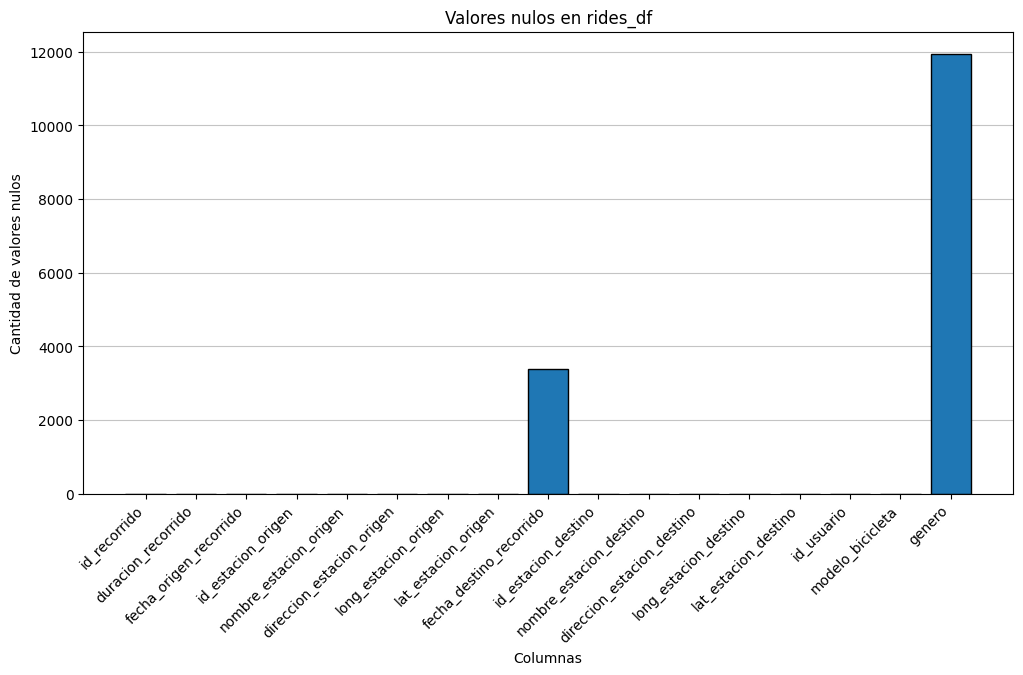

In [99]:
# Exploración de valores nulos
plt.figure(figsize=(12, 6))
plt.grid(axis='y', alpha=0.75)
plt.bar(rides_df.columns, rides_df.isnull().sum(), align='center', zorder=2, edgecolor='black')
plt.xticks(rotation=45, ha='right')
plt.title('Valores nulos en rides_df')
plt.xlabel('Columnas')
plt.ylabel('Cantidad de valores nulos')
plt.show()

##### Exploración de duraciones de recorrido

In [100]:
rides_df['duracion_recorrido_min'] = rides_df['duracion_recorrido'] / 60

In [101]:
# Recorrido mas largo en días
print(f"Recorrido más largo: {round(rides_df['duracion_recorrido'].max()/3600/24, 2)} días")

Recorrido más largo: 29.76 días


In [102]:
# Recorrido mas corto en minutos
print(f"Recorrido más corto: {round(rides_df['duracion_recorrido_min'].min(), 2)} minutos")

# Recorrido mas largo en minutos
print(f"Recorrido más largo: {round(rides_df['duracion_recorrido_min'].max(), 2)} minutos")

Recorrido más corto: 0.0 minutos
Recorrido más largo: 42852.75 minutos


In [103]:
# El usuario que más tiempo usó las bicicletas
user_durations = rides_df.groupby('id_usuario')['duracion_recorrido'].sum()
max_user_id = user_durations.idxmax()
max_user_duration = user_durations.max()

print(f"Usuario más activo: {max_user_duration/3600:.2f} hs")

Usuario más activo: 738.33 hs


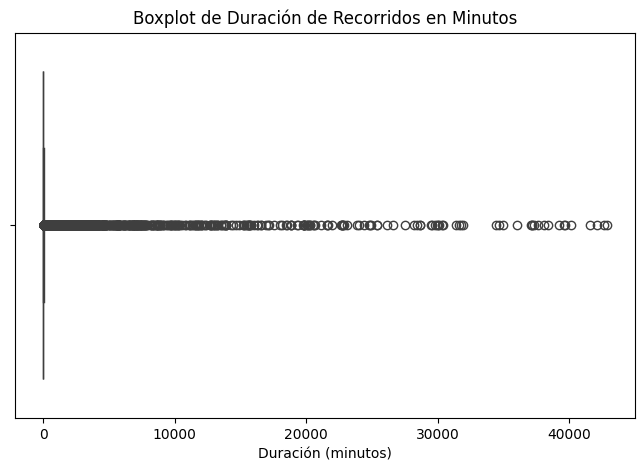

In [104]:
# Boxplot de duracion de recorridos en minutos
plt.figure(figsize=(8, 5))
sns.boxplot(x=rides_df['duracion_recorrido_min'])
plt.title('Boxplot de Duración de Recorridos en Minutos')
plt.xlabel('Duración (minutos)')
plt.show()

In [105]:
# Cuartiles en minutos
Q1 = rides_df['duracion_recorrido_min'].quantile(0.25)
Q2 = rides_df['duracion_recorrido_min'].quantile(0.50)
Q3 = rides_df['duracion_recorrido_min'].quantile(0.75)
IQR = Q3 - Q1

print("Q1 (25%):", Q1)
print("Q2 (Mediana, 50%):", Q2)
print("Q3 (75%):", Q3)
print("IQR (Rango Intercuartílico):", IQR)

Q1 (25%): 8.216666666666667
Q2 (Mediana, 50%): 14.683333333333334
Q3 (75%): 24.55
IQR (Rango Intercuartílico): 16.333333333333336


In [106]:
# Media moda mediana de duraciones (en minutos)
mean = rides_df['duracion_recorrido_min'].mean().round(2)
median = rides_df['duracion_recorrido_min'].median().round(2)
mode = rides_df['duracion_recorrido_min'].mode()[0].round(2)
var = rides_df['duracion_recorrido_min'].var().round(2)
std_dev = rides_df['duracion_recorrido_min'].std().round(2)

print(f"Media: {mean} s")
print(f"Mediana: {median} s")
print(f"Moda: {mode} s")
print(f"Varianza: {var} s²")
print(f"Desviación estándar: {std_dev} s")

Media: 21.24 s
Mediana: 14.68 s
Moda: 0.03 s
Varianza: 25507.91 s²
Desviación estándar: 159.71 s


In [107]:
print(f"Asímetría de duracion: {rides_df['duracion_recorrido_min'].skew()}")
print(f"Curtosis de duracion: {rides_df['duracion_recorrido_min'].kurtosis()}")

Asímetría de duracion: 156.24371723293666
Curtosis de duracion: 30117.530410529303


La duración de recorridos es altamente asimétrica:
- Tiene muchos valores bajos
- Tiene pocos valores extremadamente altos (estiran la cola a derecha)

La duración de recorridos tiene una curtosis muy alta:
- Tiene una distribución 'picuda'
- Tiene una cola bien pesada

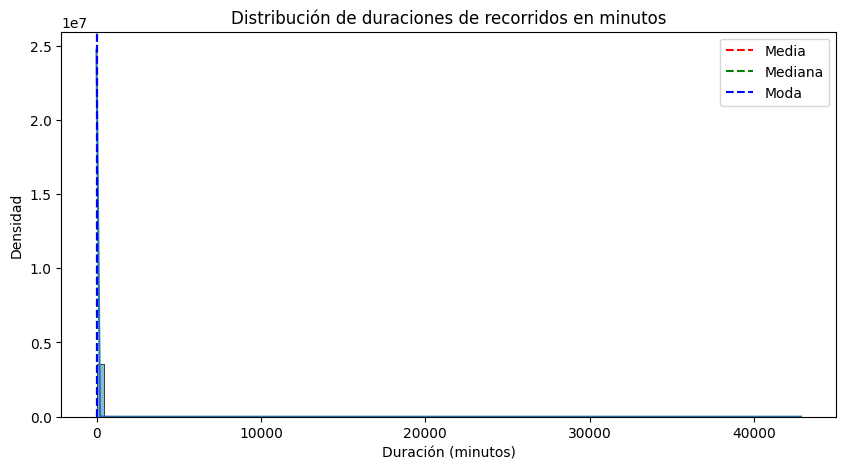

In [108]:
# Histograma de duraciones de recorridos en minutos
plt.figure(figsize=(10, 5))
ax =sns.histplot(rides_df['duracion_recorrido_min'], bins=100, kde=True)
plt.title('Distribución de duraciones de recorridos en minutos')
plt.xlabel('Duración (minutos)')
plt.ylabel('Densidad')

# Media, moda y mediana
ax.axvline(mean, color='r', linestyle='--', label='Media')
ax.axvline(median, color='g', linestyle='--', label='Mediana')
ax.axvline(mode, color='b', linestyle='--', label='Moda')
ax.legend()

plt.show()

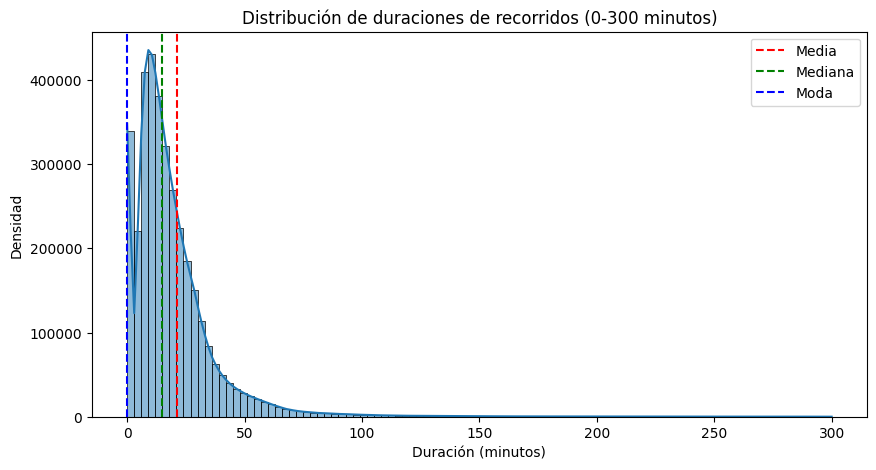

In [109]:
# Histograma de duraciones de recorridos en minutos (>0 y < 300)
mask_duration = (rides_df['duracion_recorrido_min'] > 0) & (rides_df['duracion_recorrido_min'] < 300)
plt.figure(figsize=(10, 5))
ax = sns.histplot(rides_df[mask_duration]['duracion_recorrido_min'], bins=100, kde=True)
plt.title('Distribución de duraciones de recorridos (0-300 minutos)')
plt.xlabel('Duración (minutos)')
plt.ylabel('Densidad')

# Media, moda y mediana
ax.axvline(mean, color='r', linestyle='--', label='Media')
ax.axvline(median, color='g', linestyle='--', label='Mediana')
ax.axvline(mode, color='b', linestyle='--', label='Moda')
ax.legend()

plt.show()

##### Exploración de fecha origen de recorrido

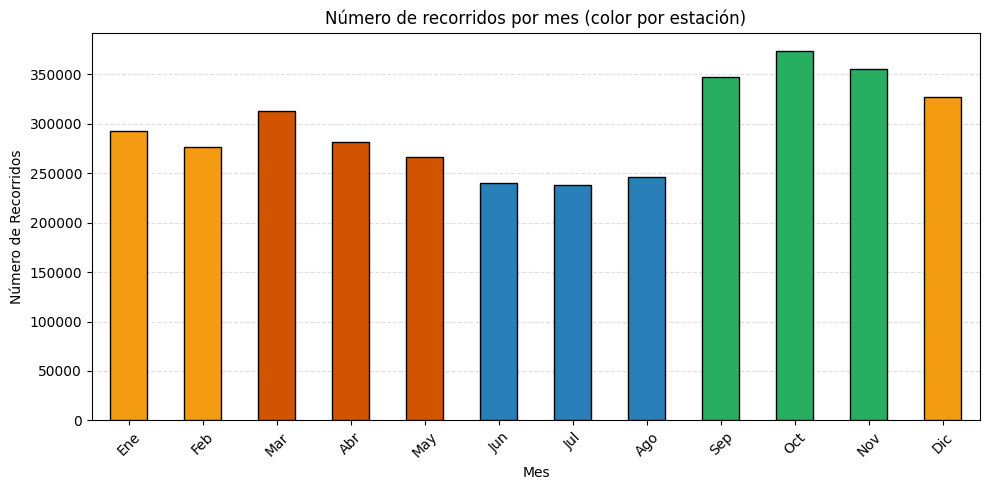

In [110]:
rides_df['fecha_origen_recorrido'] = pd.to_datetime(rides_df['fecha_origen_recorrido'])
rides_df['mes'] = rides_df['fecha_origen_recorrido'].dt.month

counts = rides_df['mes'].value_counts().reindex(range(1,13), fill_value=0).sort_index()

# Verano: Dic-Ene-Feb; Otoño: Mar-Abr-May; Invierno: Jun-Jul-Ago; Primavera: Sep-Oct-Nov
season_of = {12:'verano', 1:'verano', 2:'verano',
             3:'otoño', 4:'otoño', 5:'otoño',
             6:'invierno', 7:'invierno', 8:'invierno',
             9:'primavera', 10:'primavera', 11:'primavera'}
palette = {'verano':'#F39C12', 'otoño':'#D35400', 'invierno':'#2980B9', 'primavera':'#27AE60'}
colors = [palette[season_of[m]] for m in counts.index]

fig, ax = plt.subplots(figsize=(10, 5))
counts.plot(kind='bar', ax=ax, color=colors, edgecolor='black', zorder=3)

ax.grid(axis='y', linestyle='--', alpha=0.4, zorder=0)
ax.set_axisbelow(True)

ax.set_title('Número de recorridos por mes (color por estación)')
ax.set_xlabel('Mes'); ax.set_ylabel('Número de Recorridos')
ax.set_xticks(range(12))
ax.set_xticklabels(['Ene','Feb','Mar','Abr','May','Jun','Jul','Ago','Sep','Oct','Nov','Dic'], rotation=45)

plt.tight_layout()
plt.show()


In [111]:
# Dia de la semana con más recorridos
rides_df['dia_semana_origen_recorrido'] = rides_df['fecha_origen_recorrido'].dt.day_name()
print(f"Día de la semana con más recorridos: {rides_df['dia_semana_origen_recorrido'].value_counts().idxmax()} con {rides_df['dia_semana_origen_recorrido'].value_counts().max()} recorridos")

Día de la semana con más recorridos: Thursday con 641452 recorridos


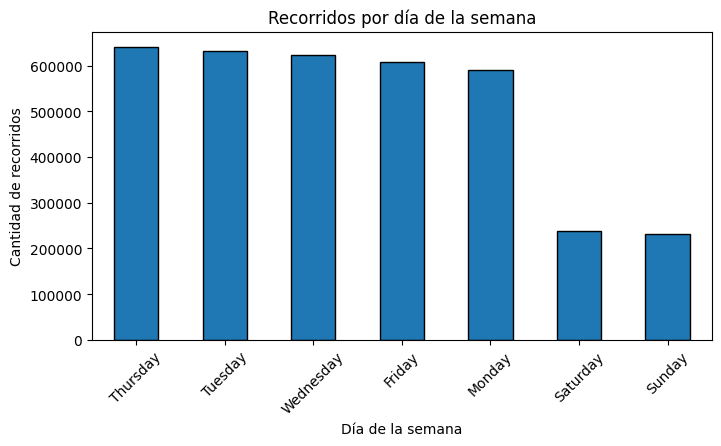

In [112]:
# Bar chart de recorridos por dia de la semana
plt.figure(figsize=(8, 4))
rides_df['dia_semana_origen_recorrido'].value_counts().plot(kind='bar', edgecolor='black')
plt.title('Recorridos por día de la semana')
plt.xlabel('Día de la semana')
plt.ylabel('Cantidad de recorridos')
plt.xticks(rotation=45)
plt.show()

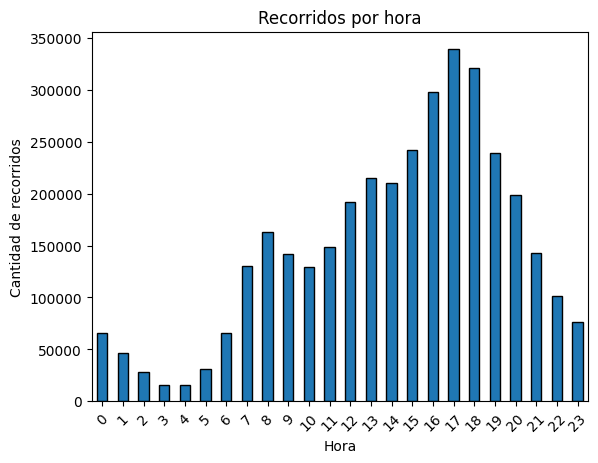

In [113]:
# Recorridos por hora
rides_df['hora_origen_recorrido'] = pd.to_datetime(rides_df['fecha_origen_recorrido'], format='%H:%M:%S', errors='coerce').dt.hour
rides_df['hora_origen_recorrido'].value_counts().sort_index().plot(kind='bar', edgecolor='black')
plt.title('Recorridos por hora')
plt.xlabel('Hora')
plt.ylabel('Cantidad de recorridos')
plt.xticks(rotation=45)
plt.show()

##### Exploración de estaciones

In [114]:
# Estaciones más usadas para iniciar recorridos
origin_top_stations = rides_df['nombre_estacion_origen'].value_counts().sort_values(ascending=False).head(5)
print(origin_top_stations)

nombre_estacion_origen
147 - Constitución           38284
014 - Pacifico               37594
368 - PLAZA DE LA SHOÁ       37201
005 - Plaza Italia           34547
001 - FACULTAD DE DERECHO    30955
Name: count, dtype: int64


In [115]:
# Estaciones más usadas para terminar recorridos
destination_top_stations = rides_df['nombre_estacion_destino'].value_counts().sort_values(ascending=False).head(5)
print(destination_top_stations)

nombre_estacion_destino
147 - Constitución           38363
368 - PLAZA DE LA SHOÁ       37425
014 - Pacifico               37278
005 - Plaza Italia           34607
001 - FACULTAD DE DERECHO    30897
Name: count, dtype: int64


In [116]:
# Mapa
caba_coords = [-34.6037, -58.3816]
m = folium.Map(location=caba_coords, zoom_start=13, tiles='OpenStreetMap')

# Origenes
cols_ori = ['nombre_estacion_origen', 'lat_estacion_origen', 'long_estacion_origen']
coords = (rides_df[rides_df['nombre_estacion_origen'].isin(origin_top_stations.index)]
          [cols_ori].dropna().drop_duplicates('nombre_estacion_origen'))

for _, r in coords.iterrows():
    nombre, lat, lon = r['nombre_estacion_origen'], float(r['lat_estacion_origen']), float(r['long_estacion_origen'])
    
    folium.Marker([lat, lon], popup=nombre, tooltip=nombre,
                  icon=folium.Icon(color='green', icon='play', prefix='fa')).add_to(m)
    
    folium.Marker([lat, lon],
        icon=folium.DivIcon(
            html=f'<div style="transform:translate(12px,-18px);'
             'background:#fff;border:1px solid rgba(0,0,0,.2);border-radius:4px;'
             'padding:2px 6px;font-size:12px;font-weight:700;color:#000;'
             'display:inline-block;max-width:180px;white-space:nowrap;'
             'overflow:hidden;text-overflow:ellipsis;pointer-events:none;">'
             f'{nombre}</div>'
        )
    ).add_to(m)

m.save('mapa_caba_top_estaciones_orig.html')

In [117]:
# Mapa
caba_coords = [-34.6037, -58.3816]
m = folium.Map(location=caba_coords, zoom_start=13, tiles='OpenStreetMap')

# Destinos
cols_dest = ['nombre_estacion_destino', 'lat_estacion_destino', 'long_estacion_destino']
coords_dest = (rides_df[rides_df['nombre_estacion_destino'].isin(destination_top_stations.index)]
               [cols_dest].dropna().drop_duplicates('nombre_estacion_destino'))

for _, r in coords_dest.iterrows():
    nombre, lat, lon = r['nombre_estacion_destino'], float(r['lat_estacion_destino']), float(r['long_estacion_destino'])
    folium.Marker([lat, lon], popup=nombre, tooltip=nombre,
                  icon=folium.Icon(color='red', icon='flag-checkered', prefix='fa')).add_to(m)
    folium.Marker([lat, lon],
        icon=folium.DivIcon(
            html=f'<div style="transform:translate(12px,-18px);'
             'background:#fff;border:1px solid rgba(0,0,0,.2);border-radius:4px;'
             'padding:2px 6px;font-size:12px;font-weight:700;color:#000;'
             'display:inline-block;max-width:180px;white-space:nowrap;'
             'overflow:hidden;text-overflow:ellipsis;pointer-events:none;">'
             f'{nombre}</div>'
        )
    ).add_to(m)

m.save('mapa_caba_top_estaciones_dest.html')

In [118]:
# Estaciones menos usadas para iniciar recorridos
origin_bottom_stations = rides_df['nombre_estacion_origen'].value_counts().sort_values(ascending=True).head(5)
print(origin_bottom_stations)

nombre_estacion_origen
040 - HERRERA    258
125 - BILBAO     268
327 - IBERA      331
321 - EZEIZA     360
326 - PICO       385
Name: count, dtype: int64


In [119]:
# Estaciones menos usadas para terminar recorridos
destination_bottom_stations = rides_df['nombre_estacion_destino'].value_counts().sort_values(ascending=True).head(5)
print(destination_bottom_stations)

nombre_estacion_destino
-- CDO Chacarita -- (Temporal)      2
363 - Udaondo                       9
291 - REPARACION DE K7             11
125 - BILBAO                      272
040 - HERRERA                     283
Name: count, dtype: int64


##### Exploración de usuarios de recorridos

In [120]:
rides_df['id_usuario'] = rides_df['id_usuario'].astype('Int64')

In [121]:
# Usuario que más recorridos hizo
top_user = rides_df['id_usuario'].value_counts().idxmax()
print(f"Usuario que más recorridos hizo: ID {top_user} con {rides_df['id_usuario'].value_counts().max()} recorridos")

Usuario que más recorridos hizo: ID 844251 con 8488 recorridos


##### Exploración de modelo de bicicleta
No aporta información significativa

In [122]:
rides_df['modelo_bicicleta'].value_counts()

modelo_bicicleta
FIT       2583213
ICONIC     977191
Name: count, dtype: int64

##### Exploración de géneros (en recorridos, algunos no tienen género asociado)

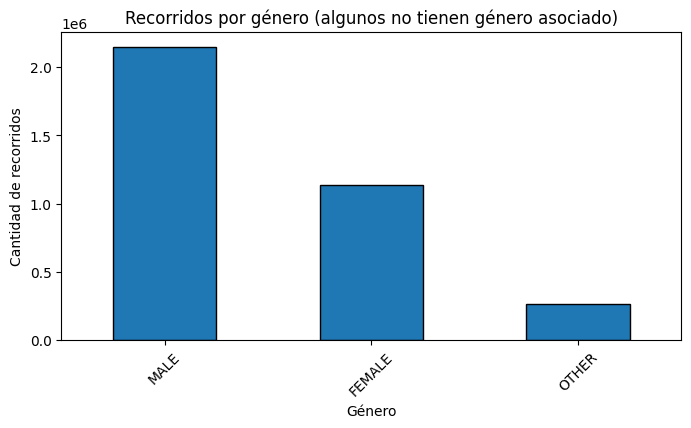

In [123]:
# Bar chart de recorridos por genero
plt.figure(figsize=(8, 4))
rides_df['genero'].value_counts().plot(kind='bar', edgecolor='black')
plt.title('Recorridos por género (algunos no tienen género asociado)')
plt.xlabel('Género')
plt.ylabel('Cantidad de recorridos')
plt.xticks(rotation=45)
plt.show()

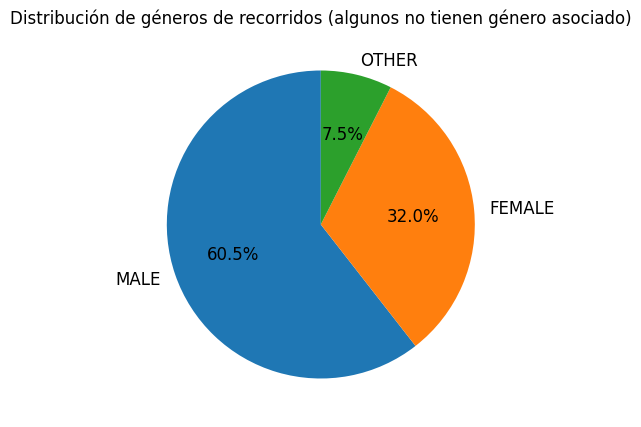

In [124]:
# Pie chart de generos de los recorridos (algunos recorridos no tienen género asociado)
plt.figure(figsize=(5, 5))
rides_df['genero'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, fontsize=12)
plt.title('Distribución de géneros de recorridos (algunos no tienen género asociado)')
plt.ylabel('')
plt.show()

### Merge datasets usuarios + recorridos?

In [125]:
# Cuántos usuarios de rides_df están en users_df?
np.isin(rides_df['id_usuario'], users_df['id_usuario']).sum()

np.int64(1136610)

No resulta útil unir ambos datasets, ya que más de un millón de recorridos no tienen `id_usuario` asociado.<br>
Esto se debe a que el dataset de usuarios 2024 solo incluye altas realizadas en ese año, mientras que el dataset de recorridos 2024 también contiene viajes de usuarios que se registraron en años anteriores.

# Split del dataset

# Análisis y tratamiento de faltantes

# Análisis y tratamiento de outliers

# Feature engineering